In [1]:
from helpers.shared_imports import *
%matplotlib inline

In [22]:
from helpers.traj import get_trajectory, generate_trajectories, filter_trajs, state_idx

**Here we generate a dataset with 26,000 trajectories**

Note that in our work we generated datasets with 200,000 trajectories.

The neural networks analysed in later notebooks were trained on this larger dataset.

In [30]:
init_conds_range = {
    'x' : (-10,10),
    'z' : (-10,10),
    'vx' : (-5,5),
    'vz' : (-5,5),
    'theta' : (-np.pi/2, np.pi/2)
}

n_repeats = 30000 # should be larger than number of trajectories desired

ampl_qoc_path = 'ampl/bebop_power.mod'

**Parallelises trajectory generation over multiple CPUs**

In [31]:
%%time

trajs, init_conds_arr, objs = \
    generate_trajectories(n_repeats,         # no. OCPs attempted
                          init_conds_range,  # intervals from which initial states sampled
                          ampl_qoc_path,     # path to ampl mod file
                          quad_params={},    # override other ampl params (e.g. mass)
                          n_jobs=40,         # number of CPUs to parallelise to
                          get_trajectory=get_trajectory)  # for QOC

CPU times: user 8.18 s, sys: 1.28 s, total: 9.46 s
Wall time: 3min 7s


In [32]:
len(trajs)

27447

**Plot objective values for all trajectories**

We do this because a minority of the trajectories are still returned which are clearly not optimal.
This is clear when looking at their objective values.

Therefore, do not always trust AMPL/SNOPT when it says *Optimal solution found* !

Text(0,0.5,'objective')

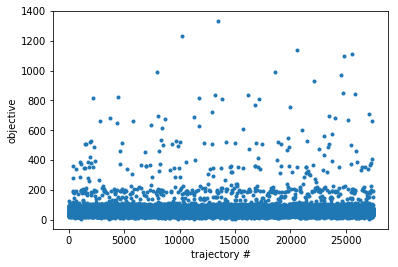

In [33]:
plt.plot(range(len(objs)), objs, '.')
plt.xlabel('trajectory #')
plt.ylabel('objective')

**Filter out trajectories with objective value greater than 100**

In [34]:
trajs, init_conds_arr, objs = filter_trajs((trajs, init_conds_arr, objs), obj_lim=100)
len(trajs)

26695

**Visualisation of all trajectories in (x,z)**

Text(0,0.5,'$z$')

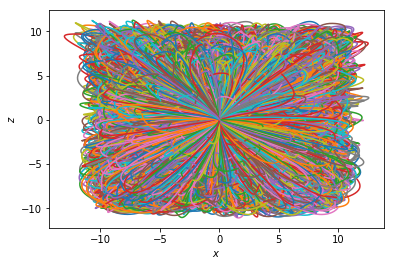

In [35]:
plt.plot(trajs[:,:,state_idx['x']].T, trajs[:,:,state_idx['z']].T)
plt.xlabel('$x$')
plt.ylabel('$z$')

**Distribution of states**

The whole point of all this is to learn a regressor mapping state to control (i.e. a machine learning problem).

It might be insightful to look at the distribution of the inputs (states). We expect this to be unbalanced since there will be clearly more states near the target state of the OCP.

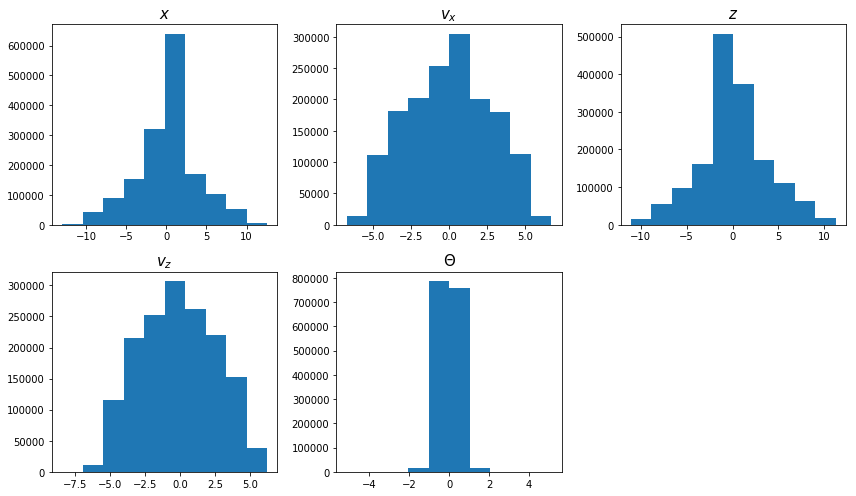

In [66]:
fig = plt.figure(figsize=(12,7))

ax = fig.add_subplot(231)
ax.hist(trajs[:,:,state_idx['x']].reshape(-1))
ax.set_title('$x$', {'size':15})

ax = fig.add_subplot(232)
ax.hist(trajs[:,:,state_idx['vx']].reshape(-1))
ax.set_title('$v_x$', {'size':15})

ax = fig.add_subplot(233)
ax.hist(trajs[:,:,state_idx['z']].reshape(-1))
ax.set_title('$z$', {'size':15})

ax = fig.add_subplot(234)
ax.hist(trajs[:,:,state_idx['vz']].reshape(-1))
ax.set_title('$v_z$', {'size':15})

ax = fig.add_subplot(235)
ax.hist(trajs[:,:,state_idx['theta']].reshape(-1))
ax.set_title('$\Theta$', {'size':15})

plt.tight_layout()
plt.show()

**Histogram of controls at target state**

In deterministic optimal control, each state (regardless of its occurence along a trajectory) is associated to a unique control.

This applies to every state except the target.

At the target, the control is not well-defined (*think about it*).

Our solver for QOC appears to give a control that is a smooth continuation of the previous controls in the trajectory.

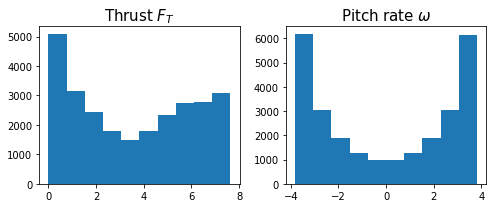

In [71]:
fig = plt.figure(figsize=(7,3))

ax = fig.add_subplot(121)
ax.hist(trajs[:,-1, state_idx['u1']])
ax.set_title('Thrust $F_T$', {'size':15})

ax = fig.add_subplot(122)
ax.hist(trajs[:,-1, state_idx['u2']])
ax.set_title('Pitch rate $\omega$', {'size':15})

plt.tight_layout()
plt.show()

**Manually set controls at target**

We would like the controls at the target to be such that the system remains at the target in terms of $x$ and $z$ if a next time step would be evaluated.

In [73]:
trajs2 = np.copy(trajs)

# numerical parameters taken from ampl file
mass = 0.38905
grav = 9.81

trajs2[:,-1, state_idx['u1']] = mass*grav
trajs2[:,-1,state_idx['u2']] = 0.0

**Export trajectories**

In [74]:
dataset = trajs2[:26000,:,:] # ensures exported dataset is under 100 MB (GitHub limit)
dataset_path = 'datasets/bebop_power.npy'
np.save(dataset_path, dataset)